In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pickle
import string
import requests
import collections
import io
import tarfile
import urllib.request
import text_helpers
from nltk.corpus import stopwords
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [2]:
# Make a saving directory if it doesn't exist
data_folder_name = 'temp'
if not os.path.exists(data_folder_name):
    os.makedirs(data_folder_name)

In [3]:
sess = tf.Session()

In [4]:
batch_size = 500
vocabulary_size = 7500
generations = 100000
model_learning_rate = 0.001

embedding_size = 200   # Word embedding size
doc_embedding_size = 100   # Document embedding size
concatenated_size = embedding_size + doc_embedding_size

num_sampled = int(batch_size/2)    # Number of negative examples to sample.
window_size = 3       # How many words to consider to the left.

# Add checkpoints to training
save_embeddings_every = 5000
print_valid_every = 5000
print_loss_every = 100

In [5]:
# Declare stop words
#stops = stopwords.words('english')
stops = []

# We pick a few test words for validation.
valid_words = ['love', 'hate', 'happy', 'sad', 'man', 'woman']
# Later we will have to transform these into indices

# Load the movie review data
print('Loading Data')
texts, target = text_helpers.load_movie_data()

# Normalize text
print('Normalizing Text Data')
texts = text_helpers.normalize_text(texts, stops)

# Texts must contain at least 3 words
target = [target[ix] for ix, x in enumerate(texts) if len(x.split()) > window_size]
texts = [x for x in texts if len(x.split()) > window_size]    
assert(len(target)==len(texts))
print('Done.')

Loading Data
Normalizing Text Data
Done.


In [6]:
# Build our data set and dictionaries
print('Creating Dictionary')
word_dictionary = text_helpers.build_dictionary(texts, vocabulary_size)
word_dictionary_rev = dict(zip(word_dictionary.values(), word_dictionary.keys()))
text_data = text_helpers.text_to_numbers(texts, word_dictionary)

# Get validation word keys
valid_examples = [word_dictionary[x] for x in valid_words]
print('Done.')

Creating Dictionary
Done.


In [7]:
print('Creating Model')
# Define Embeddings:
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
doc_embeddings = tf.Variable(tf.random_uniform([len(texts), doc_embedding_size], -1.0, 1.0))

# NCE loss parameters
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, concatenated_size],
                                               stddev=1.0 / np.sqrt(concatenated_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Create data/target placeholders
x_inputs = tf.placeholder(tf.int32, shape=[None, window_size + 1]) # plus 1 for doc index
y_target = tf.placeholder(tf.int32, shape=[None, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

# Lookup the word embedding
# Add together element embeddings in window:
embed = tf.zeros([batch_size, embedding_size])
for element in range(window_size):
    embed += tf.nn.embedding_lookup(embeddings, x_inputs[:, element])

doc_indices = tf.slice(x_inputs, [0,window_size],[batch_size,1])
doc_embed = tf.nn.embedding_lookup(doc_embeddings,doc_indices)

# concatenate embeddings
final_embed = tf.concat(axis=1, values=[embed, tf.squeeze(doc_embed)])
print('Done.')

Creating Model
Done.


In [8]:
# Get loss from prediction
loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                     biases=nce_biases,
                                     labels=y_target,
                                     inputs=final_embed,
                                     num_sampled=num_sampled,
                                     num_classes=vocabulary_size))
                                     
# Create optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=model_learning_rate)
train_step = optimizer.minimize(loss)

# Cosine similarity between words
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Create model saving operation
saver = tf.train.Saver({"embeddings": embeddings, "doc_embeddings": doc_embeddings})

#Add variable initializer.
init = tf.global_variables_initializer()
sess.run(init)

In [12]:
# Run the doc2vec model.
print('Starting Training')
loss_vec = []
loss_x_vec = []
for i in range(generations):
    batch_inputs, batch_labels = text_helpers.generate_batch_data(text_data, batch_size,
                                                                  window_size, method='doc2vec')
    feed_dict = {x_inputs : batch_inputs, y_target : batch_labels}

    # Run the train step
    sess.run(train_step, feed_dict=feed_dict)

    # Return the loss
    if (i+1) % print_loss_every == 0:
        loss_val = sess.run(loss, feed_dict=feed_dict)
        loss_vec.append(loss_val)
        loss_x_vec.append(i+1)
        print('Loss at step {} : {}'.format(i+1, loss_val))
      
    # Validation: Print some random words and top 5 related words
    if (i+1) % print_valid_every == 0:
        sim = sess.run(similarity, feed_dict=feed_dict)
        for j in range(len(valid_words)):
            valid_word = word_dictionary_rev[valid_examples[j]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[j, :]).argsort()[1:top_k+1]
            log_str = "Nearest to {}:".format(valid_word)
            for k in range(top_k):
                close_word = word_dictionary_rev[nearest[k]]
                log_str = '{} {},'.format(log_str, close_word)
            print(log_str)
            
    # Save dictionary + embeddings
    if (i+1) % save_embeddings_every == 0:
        # Save vocabulary dictionary
        with open(os.path.join(data_folder_name,'movie_vocab.pkl'), 'wb') as f:
            pickle.dump(word_dictionary, f)
        
        # Save embeddings
        model_checkpoint_path = os.path.join(os.getcwd(),data_folder_name,'doc2vec_movie_embeddings.ckpt')
        save_path = saver.save(sess, model_checkpoint_path)
        print('Model saved in file: {}'.format(save_path))

Starting Training
Loss at step 100 : 26.123146057128906
Loss at step 200 : 21.973981857299805
Loss at step 300 : 14.549206733703613
Loss at step 400 : 18.90227699279785
Loss at step 500 : 14.576988220214844
Loss at step 600 : 16.81222152709961
Loss at step 700 : 24.745500564575195
Loss at step 800 : 10.66199779510498
Loss at step 900 : 21.346149444580078
Loss at step 1000 : 18.498979568481445
Loss at step 1100 : 24.30424690246582
Loss at step 1200 : 16.300081253051758
Loss at step 1300 : 19.17396354675293
Loss at step 1400 : 18.970230102539062
Loss at step 1500 : 13.918855667114258
Loss at step 1600 : 19.595441818237305
Loss at step 1700 : 16.918054580688477
Loss at step 1800 : 18.993946075439453
Loss at step 1900 : 12.8231840133667
Loss at step 2000 : 21.682323455810547
Loss at step 2100 : 18.36751937866211
Loss at step 2200 : 20.192577362060547
Loss at step 2300 : 15.472284317016602
Loss at step 2400 : 25.392480850219727
Loss at step 2500 : 15.340847969055176
Loss at step 2600 : 17.0

Loss at step 17800 : 15.908406257629395
Loss at step 17900 : 18.37805938720703
Loss at step 18000 : 18.530357360839844
Loss at step 18100 : 17.730710983276367
Loss at step 18200 : 15.952566146850586
Loss at step 18300 : 17.059362411499023
Loss at step 18400 : 18.240859985351562
Loss at step 18500 : 17.84923553466797
Loss at step 18600 : 16.863605499267578
Loss at step 18700 : 23.04124641418457
Loss at step 18800 : 17.826915740966797
Loss at step 18900 : 13.707048416137695
Loss at step 19000 : 14.692239761352539
Loss at step 19100 : 20.658960342407227
Loss at step 19200 : 15.308323860168457
Loss at step 19300 : 18.180631637573242
Loss at step 19400 : 19.274953842163086
Loss at step 19500 : 19.886987686157227
Loss at step 19600 : 14.36757755279541
Loss at step 19700 : 17.550872802734375
Loss at step 19800 : 18.948026657104492
Loss at step 19900 : 19.043495178222656
Loss at step 20000 : 17.562175750732422
Nearest to love: like, in, a, the, are,
Nearest to hate: thick, static, descends, re

Model saved in file: C:\Users\Evan\Documents\TensorflowExamples\temp\doc2vec_movie_embeddings.ckpt
Loss at step 35100 : 16.262231826782227
Loss at step 35200 : 15.797905921936035
Loss at step 35300 : 20.209421157836914
Loss at step 35400 : 14.266108512878418
Loss at step 35500 : 19.046253204345703
Loss at step 35600 : 17.642086029052734
Loss at step 35700 : 17.589786529541016
Loss at step 35800 : 14.884262084960938
Loss at step 35900 : 11.349271774291992
Loss at step 36000 : 17.800336837768555
Loss at step 36100 : 14.63790512084961
Loss at step 36200 : 17.14775848388672
Loss at step 36300 : 13.55642032623291
Loss at step 36400 : 11.982966423034668
Loss at step 36500 : 15.095621109008789
Loss at step 36600 : 14.349234580993652
Loss at step 36700 : 13.643282890319824
Loss at step 36800 : 13.909433364868164
Loss at step 36900 : 13.468755722045898
Loss at step 37000 : 15.487139701843262
Loss at step 37100 : 13.6512451171875
Loss at step 37200 : 15.477781295776367
Loss at step 37300 : 14.94

Loss at step 52300 : 11.252276420593262
Loss at step 52400 : 11.752406120300293
Loss at step 52500 : 20.518871307373047
Loss at step 52600 : 19.557241439819336
Loss at step 52700 : 12.959529876708984
Loss at step 52800 : 15.395519256591797
Loss at step 52900 : 17.045181274414062
Loss at step 53000 : 13.79113483428955
Loss at step 53100 : 16.898427963256836
Loss at step 53200 : 12.566767692565918
Loss at step 53300 : 17.570972442626953
Loss at step 53400 : 10.656020164489746
Loss at step 53500 : 11.923474311828613
Loss at step 53600 : 15.66443920135498
Loss at step 53700 : 13.12232780456543
Loss at step 53800 : 16.689939498901367
Loss at step 53900 : 18.426223754882812
Loss at step 54000 : 15.300277709960938
Loss at step 54100 : 10.216903686523438
Loss at step 54200 : 13.025334358215332
Loss at step 54300 : 13.845613479614258
Loss at step 54400 : 15.691981315612793
Loss at step 54500 : 13.744384765625
Loss at step 54600 : 14.357818603515625
Loss at step 54700 : 14.537343978881836
Loss a

Loss at step 69800 : 14.437731742858887
Loss at step 69900 : 15.051528930664062
Loss at step 70000 : 14.665611267089844
Nearest to love: like, in, a, are, from,
Nearest to hate: thick, static, descends, crossroads, remarkable,
Nearest to happy: proportions, in, on, bumper, ethnic,
Nearest to sad: gives, adolescent, us, masterful, end,
Nearest to man: are, enough, of, very, never,
Nearest to woman: art, what, scathing, steers, special,
Model saved in file: C:\Users\Evan\Documents\TensorflowExamples\temp\doc2vec_movie_embeddings.ckpt
Loss at step 70100 : 16.35041618347168
Loss at step 70200 : 17.03472900390625
Loss at step 70300 : 13.564021110534668
Loss at step 70400 : 14.323997497558594
Loss at step 70500 : 16.988502502441406
Loss at step 70600 : 12.647048950195312
Loss at step 70700 : 9.897188186645508
Loss at step 70800 : 12.652627944946289
Loss at step 70900 : 14.715295791625977
Loss at step 71000 : 15.872590065002441
Loss at step 71100 : 15.057087898254395
Loss at step 71200 : 11.4

Loss at step 86200 : 12.549219131469727
Loss at step 86300 : 10.147348403930664
Loss at step 86400 : 14.250308990478516
Loss at step 86500 : 10.044286727905273
Loss at step 86600 : 12.764043807983398
Loss at step 86700 : 11.49892807006836
Loss at step 86800 : 12.086411476135254
Loss at step 86900 : 12.301789283752441
Loss at step 87000 : 12.082510948181152
Loss at step 87100 : 14.934096336364746
Loss at step 87200 : 12.427534103393555
Loss at step 87300 : 15.83195972442627
Loss at step 87400 : 13.05290699005127
Loss at step 87500 : 9.560425758361816
Loss at step 87600 : 15.854874610900879
Loss at step 87700 : 12.722572326660156
Loss at step 87800 : 18.23583984375
Loss at step 87900 : 11.492841720581055
Loss at step 88000 : 11.695260047912598
Loss at step 88100 : 16.607778549194336
Loss at step 88200 : 13.82007122039795
Loss at step 88300 : 13.240906715393066
Loss at step 88400 : 11.026830673217773
Loss at step 88500 : 13.756187438964844
Loss at step 88600 : 14.176676750183105
Loss at s

In [17]:
max_words = 20
logistic_batch_size = 500

In [18]:
# Need to keep the indices sorted to keep track of document index
train_indices = np.sort(np.random.choice(len(target), round(0.8*len(target)), replace=False))
test_indices = np.sort(np.array(list(set(range(len(target))) - set(train_indices))))
texts_train = [x for ix, x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix, x in enumerate(texts) if ix in test_indices]
target_train = np.array([x for ix, x in enumerate(target) if ix in train_indices])
target_test = np.array([x for ix, x in enumerate(target) if ix in test_indices])

# Convert texts to lists of indices
text_data_train = np.array(text_helpers.text_to_numbers(texts_train, word_dictionary))
text_data_test = np.array(text_helpers.text_to_numbers(texts_test, word_dictionary))

# Pad/crop movie reviews to specific length
text_data_train = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_train]])
text_data_test = np.array([x[0:max_words] for x in [y+[0]*max_words for y in text_data_test]])

In [19]:
# Define Logistic placeholders
log_x_inputs = tf.placeholder(tf.int32, shape=[None, max_words + 1]) # plus 1 for doc index
log_y_target = tf.placeholder(tf.int32, shape=[None, 1])

# Define logistic embedding lookup (needed if we have two different batch sizes)
# Add together element embeddings in window:
log_embed = tf.zeros([logistic_batch_size, embedding_size])
for element in range(max_words):
    log_embed += tf.nn.embedding_lookup(embeddings, log_x_inputs[:, element])

log_doc_indices = tf.slice(log_x_inputs, [0,max_words],[logistic_batch_size,1])
log_doc_embed = tf.nn.embedding_lookup(doc_embeddings,log_doc_indices)

# concatenate embeddings
log_final_embed = tf.concat(axis=1, values=[log_embed, tf.squeeze(log_doc_embed)])

# Define model:
# Create variables for logistic regression
A = tf.Variable(tf.random_normal(shape=[concatenated_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Declare logistic model (sigmoid in loss function)
model_output = tf.add(tf.matmul(log_final_embed, A), b)

In [20]:
# Declare loss function (Cross Entropy loss)
logistic_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output, labels=tf.cast(log_y_target, tf.float32)))

# Actual Prediction
prediction = tf.round(tf.sigmoid(model_output))
predictions_correct = tf.cast(tf.equal(prediction, tf.cast(log_y_target, tf.float32)), tf.float32)
accuracy = tf.reduce_mean(predictions_correct)

# Declare optimizer
logistic_opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
logistic_train_step = logistic_opt.minimize(logistic_loss, var_list=[A, b])

# Intitialize Variables
init = tf.global_variables_initializer()
sess.run(init)

In [21]:
# Start Logistic Regression
print('Starting Logistic Doc2Vec Model Training')
train_loss = []
test_loss = []
train_acc = []
test_acc = []
i_data = []
for i in range(10000):
    rand_index = np.random.choice(text_data_train.shape[0], size=logistic_batch_size)
    rand_x = text_data_train[rand_index]
    # Append review index at the end of text data
    rand_x_doc_indices = train_indices[rand_index]
    rand_x = np.hstack((rand_x, np.transpose([rand_x_doc_indices])))
    rand_y = np.transpose([target_train[rand_index]])
    
    feed_dict = {log_x_inputs : rand_x, log_y_target : rand_y}
    sess.run(logistic_train_step, feed_dict=feed_dict)
    
    # Only record loss and accuracy every 100 generations
    if (i+1)%100==0:
        rand_index_test = np.random.choice(text_data_test.shape[0], size=logistic_batch_size)
        rand_x_test = text_data_test[rand_index_test]
        # Append review index at the end of text data
        rand_x_doc_indices_test = test_indices[rand_index_test]
        rand_x_test = np.hstack((rand_x_test, np.transpose([rand_x_doc_indices_test])))
        rand_y_test = np.transpose([target_test[rand_index_test]])
        
        test_feed_dict = {log_x_inputs: rand_x_test, log_y_target: rand_y_test}
        
        i_data.append(i+1)

        train_loss_temp = sess.run(logistic_loss, feed_dict=feed_dict)
        train_loss.append(train_loss_temp)
        
        test_loss_temp = sess.run(logistic_loss, feed_dict=test_feed_dict)
        test_loss.append(test_loss_temp)
        
        train_acc_temp = sess.run(accuracy, feed_dict=feed_dict)
        train_acc.append(train_acc_temp)
    
        test_acc_temp = sess.run(accuracy, feed_dict=test_feed_dict)
        test_acc.append(test_acc_temp)
    if (i+1)%500==0:
        acc_and_loss = [i+1, train_loss_temp, test_loss_temp, train_acc_temp, test_acc_temp]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss (Test Loss): {:.2f} ({:.2f}). Train Acc (Test Acc): {:.2f} ({:.2f})'.format(*acc_and_loss))

Starting Logistic Doc2Vec Model Training
Generation # 500. Train Loss (Test Loss): 6.98 (7.00). Train Acc (Test Acc): 0.50 (0.51)
Generation # 1000. Train Loss (Test Loss): 5.71 (4.76). Train Acc (Test Acc): 0.49 (0.54)
Generation # 1500. Train Loss (Test Loss): 3.30 (3.53). Train Acc (Test Acc): 0.55 (0.58)
Generation # 2000. Train Loss (Test Loss): 2.62 (2.66). Train Acc (Test Acc): 0.54 (0.56)
Generation # 2500. Train Loss (Test Loss): 2.18 (2.37). Train Acc (Test Acc): 0.55 (0.55)
Generation # 3000. Train Loss (Test Loss): 2.35 (2.49). Train Acc (Test Acc): 0.55 (0.53)
Generation # 3500. Train Loss (Test Loss): 2.17 (2.45). Train Acc (Test Acc): 0.56 (0.51)
Generation # 4000. Train Loss (Test Loss): 2.01 (2.02). Train Acc (Test Acc): 0.58 (0.57)
Generation # 4500. Train Loss (Test Loss): 2.17 (1.97). Train Acc (Test Acc): 0.55 (0.60)
Generation # 5000. Train Loss (Test Loss): 2.43 (2.70). Train Acc (Test Acc): 0.57 (0.52)
Generation # 5500. Train Loss (Test Loss): 1.80 (2.02). Trai

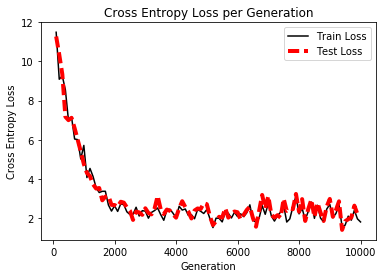

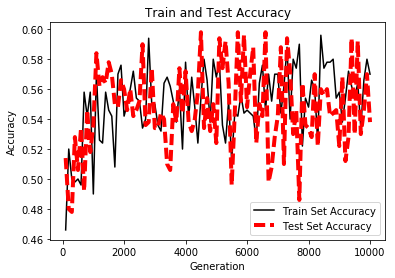

In [22]:
# Plot loss over time
plt.plot(i_data, train_loss, 'k-', label='Train Loss')
plt.plot(i_data, test_loss, 'r--', label='Test Loss', linewidth=4)
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.legend(loc='upper right')
plt.show()

# Plot train and test accuracy
plt.plot(i_data, train_acc, 'k-', label='Train Set Accuracy')
plt.plot(i_data, test_acc, 'r--', label='Test Set Accuracy', linewidth=4)
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()